In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import os
import numpy as np
import pandas as pd

In [15]:
import lib
import plotting

In [16]:
from multiprocessing import Pool
import pickle
from collections import defaultdict

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score
from sklearn.decomposition import PCA

In [18]:
from configparser import ConfigParser
cfg = ConfigParser()
cfg.read("config.cfg")

['config.cfg']

In [19]:
from tqdm._tqdm_notebook import tqdm_notebook as tqdm # we manually import the notebook submodule as the normal one struggles with jupyterlab
tqdm.pandas() # this enables us to use progress_apply instead of apply

In [20]:
results_prefix = "[WIKIDATA_10]"

sequence_file = os.path.join(cfg.get("directory", "exchange"), results_prefix + "001_clustering.p")
labels_file = os.path.join(cfg.get("directory", "exchange"), "[wikidata]004_labels.p")

In [21]:
df = pd.read_pickle(sequence_file)
labels = pd.read_pickle(labels_file)['label'].values
df.head()

,bot_name,bot_sequence,length,length_nobreak,sequence,sequence_readable,user_id,user_name,stat_dist,kmeans_4,kmeans_8
0,False,False,1517,1385,"[REVERT_MANUAL, BREAK, CLAIM_CREATE, BREAK, CL...","[Revert Item, Break, Create Claim, Break, Crea...",1,Hoo man,"[0.033592832488441825, 0.029154644609674315, 0...",0,3
1,False,False,44,23,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...","[Add Sitelink, Break, Add Sitelink, Break, Add...",100012,Kane 14,"[0.02586206896551723, 0.025862068965517227, 0....",2,1
2,False,False,17,12,"[LABEL_UPDATE, ALIAS_ADD, BREAK, CLAIM_CREATE,...","[Edit Label, Add Item Alias, Break, Create Cla...",1000197,Zaizone,"[0.026205469193709592, 0.07779210211701826, 0....",1,5
3,False,False,91,82,"[SITELINK_UPDATE, BREAK, LABEL_ADD, CLAIM_CREA...","[Edit Sitelink, Break, Add Label, Create Claim...",1001159,Gogo hr,"[0.04118566424353361, 0.03162035177772598, 0.0...",0,0
4,False,False,21,12,"[DESCRIPTION_ADD, BREAK, DESCRIPTION_UPDATE, D...","[Add Description, Break, Edit Description, Add...",1001194,Phylosofo,"[0.08620689655172406, 0.025862068965517255, 0....",1,7


In [22]:
len(df)

38429

In [23]:
df = df.loc[df["length_nobreak"] >= cfg.getint("kmeans", "min_num_changes")].reset_index(drop=True)

In [24]:
len(df)

38429

In [25]:
break_label = cfg.get("preprocessing", "break_label")
break_label

'BREAK'

In [26]:
df.head()

,bot_name,bot_sequence,length,length_nobreak,sequence,sequence_readable,user_id,user_name,stat_dist,kmeans_4,kmeans_8
0,False,False,1517,1385,"[REVERT_MANUAL, BREAK, CLAIM_CREATE, BREAK, CL...","[Revert Item, Break, Create Claim, Break, Crea...",1,Hoo man,"[0.033592832488441825, 0.029154644609674315, 0...",0,3
1,False,False,44,23,"[SITELINK_ADD, BREAK, SITELINK_ADD, BREAK, SIT...","[Add Sitelink, Break, Add Sitelink, Break, Add...",100012,Kane 14,"[0.02586206896551723, 0.025862068965517227, 0....",2,1
2,False,False,17,12,"[LABEL_UPDATE, ALIAS_ADD, BREAK, CLAIM_CREATE,...","[Edit Label, Add Item Alias, Break, Create Cla...",1000197,Zaizone,"[0.026205469193709592, 0.07779210211701826, 0....",1,5
3,False,False,91,82,"[SITELINK_UPDATE, BREAK, LABEL_ADD, CLAIM_CREA...","[Edit Sitelink, Break, Add Label, Create Claim...",1001159,Gogo hr,"[0.04118566424353361, 0.03162035177772598, 0.0...",0,0
4,False,False,21,12,"[DESCRIPTION_ADD, BREAK, DESCRIPTION_UPDATE, D...","[Add Description, Break, Edit Description, Add...",1001194,Phylosofo,"[0.08620689655172406, 0.025862068965517255, 0....",1,7


In [27]:
print(len(df), df['length'].sum())
#df = df.loc[~df['is_bot']].reset_index(drop=True)
print(len(df), df['length'].sum())

38429 76343309
38429 76343309


In [28]:
length_full = df.sort_values("length", ascending=False)['length'].values
length_nobreak = df.sort_values("length_nobreak", ascending=False)['length_nobreak'].values

In [29]:
from matplotlib import pyplot as plt

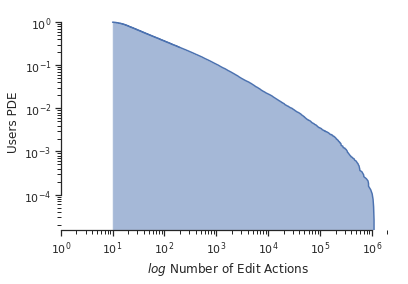

In [30]:
import seaborn as sns
import matplotlib

fig, ax = plt.subplots()
ax.loglog(length_full, np.linspace(0,1,len(length_full)))
ax.fill_between(length_full, np.linspace(0,1,len(length_full)), alpha=0.5)
ax.set_xlim(left=1)
#ax.set_ylim(0,1)
#ax.plot(length_nobreak)
#ax.set_xscale("log")
#ax.set_yscale("log", nonposy='clip')
ax.set_ylabel("Users PDE")
ax.set_xlabel("$log$ Number of Edit Actions")
#ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
sns.despine(fig, trim=True)

In [31]:
fig.tight_layout()
store_path = os.path.join(cfg.get("directory", "results"), results_prefix + "dataset_pde")
fig.savefig(store_path + ".png", transparent=True, bbox_inches="tight")
fig.savefig(store_path + ".pdf", transparent=True, bbox_inches="tight")

/home/pkasper/python/Python-3.7.1/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/pkasper/python/Python-3.7.1/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
  (prop.get_family(), self.defaultFamily[fontext]))
